# Qualitative Evaluation of Model

**Goal**: using a trained model, evaluate AUC scores for classes individually

1. Load model
2. Load dataset
3. Split dataset based on label
4. Evaluate the AUC score of the model on each label
5. Generate plot AUC scores.
6. Provide two examples where the model struggled and one where it succeeded 

In [108]:
import torch
from utils.dataset import MagnaTagATune
from model import Model
import os
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [ ]:
# Move data to appropriate device
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")
print(f'Running model on device {DEVICE}')

MODEL_PATH = "../models/CNN_bs=10_lr=0.005_mom=0.99_model.pth"
model = Model(256, 256)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

In [61]:
# Load the train, validation and test datasets and create
dataset_root = os.path.join("..", "data", "MagnaTagATune")

test_labels_path = os.path.join(dataset_root, "annotations", "new_test_labels.pkl")
samples_path = os.path.join(dataset_root, "samples")
test_dataset = MagnaTagATune(test_labels_path, samples_path)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    shuffle=False,
    pin_memory=True,
)

Loading data from ../data/MagnaTagATune/annotations/new_test_labels.pkl...


In [63]:
all_preds = []

# No need to track gradients for validation, we're not optimizing.
with torch.no_grad():
    for _, batch, _ in test_loader:
        batch = batch.to(DEVICE)
        logits = model(batch)
        preds = logits.cpu().numpy()
        all_preds.extend(list(preds))

all_preds = torch.tensor(np.array(all_preds)).to(DEVICE)

In [102]:
gts = pd.read_pickle(test_labels_path)

labels = []
for i in range(len(gts.iloc[:]['label'])):
    # labels.append(gts[i][2].numpy())                             # A 50D Ground Truth binary vector
    labels.append(np.array(gts.iloc[i]['label']).astype(float))    # A 50D Ground Truth binary vector
    # model_outs.append(preds[i].cpu().numpy()) # A 50D vector that assigns probability to each class
labels = np.array(labels).astype(float)

tag_auc_scores = []


tag_auc_scores = roc_auc_score(y_true=labels, y_score=all_preds, multi_class='ovr', average=None)
tag_auc_scores

array([0.84953514, 0.91036305, 0.77032354, 0.91468036, 0.803957  ,
       0.89781035, 0.95267642, 0.8707994 , 0.86748684, 0.94479059,
       0.84802373, 0.73395959, 0.80385193, 0.80989813, 0.7424017 ,
       0.80661588, 0.78118851, 0.73431463, 0.80549744, 0.96467573,
       0.87771755, 0.91599461, 0.97937073, 0.74956399, 0.86438631,
       0.89480892, 0.77786144, 0.80808902, 0.80488671, 0.6556832 ,
       0.63093767, 0.63171004, 0.92301181, 0.86188752, 0.85578636,
       0.8877551 , 0.88859149, 0.97463353, 0.74572261, 0.76727227,
       0.76852272, 0.78373935, 0.82780697, 0.73337372, 0.75385635,
       0.76027247, 0.92219849, 0.86704323, 0.74233863, 0.74011865])

<BarContainer object of 50 artists>

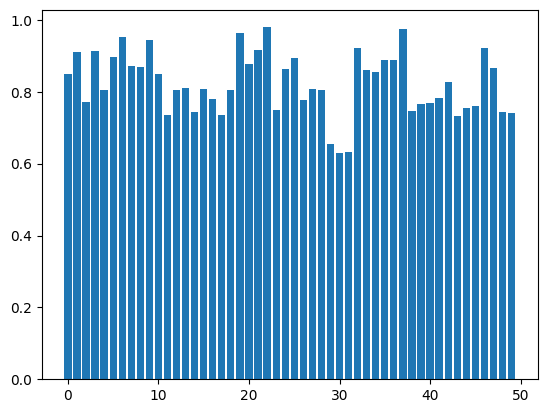

In [111]:
plt.bar(range(50), tag_auc_scores)